# Load metadata

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc

from ALLCools.clustering import \
    tsne, \
    significant_pc_test, \
    filter_regions, \
    remove_black_list_region, \
    lsi, \
    binarize_matrix
from ALLCools.plot import *

In [2]:
import glob
metafiles = glob.glob("/gale/netapp/DoD/wenliang/projects/06.Flu/00.data/*/stats/MappingSummary.csv.gz")
meta_tables = list()
for metafile in metafiles:
    meta_df = pd.read_csv(metafile, index_col=0)
    meta_tables.append(meta_df)
metadata = pd.concat(meta_tables)

In [3]:
import re
import string

metadata['sampleID'] = metadata['Plate'].apply(lambda x: "_".join(x.split("_")[0:2]))

alphabet_string = string.ascii_uppercase
alphabet_list = list(alphabet_string)
abc = alphabet_list[0:16]
num = list(range(16))
num2abc = dict(zip(num, abc))

wellID2cell = pd.read_csv("../../00.data/wellID2cell.tsv", sep="\t", names=['well', 'cell'])
well2cell = dict(zip(wellID2cell['well'], wellID2cell['cell']))

rowIDs = [num2abc[x] for x in metadata['Row384']]
colIDs = metadata['Col384'].to_list()
wellIDs = [str(rowIDs[x]) + str(colIDs[x]) for x in range(len(rowIDs))]
metadata['cell_type'] = [well2cell[x] for x in wellIDs]

sampleInfo = pd.read_csv("../../00.data/metadata.tsv", sep="\t")
# sampleInfo['PlateID'] = sampleInfo['PlateID'].apply(lambda x: "OP_" + str(x))
# id2sex = dict(zip(sampleInfo['Sample'], sampleInfo['Sex']))
id2visit = dict(zip(sampleInfo['Sample'], sampleInfo['Visit']))
id2donor = dict(zip(sampleInfo['Sample'], sampleInfo['SubjectID']))

metadata['Day'] = [id2visit[x] for x in metadata['sampleID']]
# metadata['Age'] = [id2age[x] for x in metadata['sampleID']]
metadata['Donor'] = [id2donor[x] for x in metadata['sampleID']]


# 1. Filtering

19940 / 19944 cells (100.0%) passed the MappingRate cutoff 0.5.


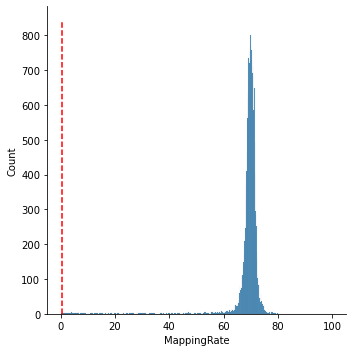

In [5]:
# Basic filtering parameters
mapping_rate_cutoff = 0.5
mapping_rate_col_name = 'MappingRate'  # Name may change
final_reads_cutoff = 500000
final_reads_col_name = 'FinalmCReads'  # Name may change
mcg_cutoff = 0.5
mcg_col_name = 'mCGFrac'  # Name may change

_cutoff = mapping_rate_cutoff
_col_name = mapping_rate_col_name

metadata['MappingRate'] = (metadata['R1MappingRate'] + metadata['R2MappingRate'])/2.0
total_cells = metadata.shape[0]
# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 100))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

mapping_rate_judge = metadata[_col_name] > _cutoff
_passed_cells = mapping_rate_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

19331 / 19944 cells (96.9%) passed the FinalmCReads cutoff 500000.


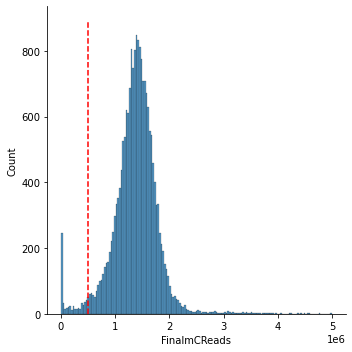

In [6]:
_cutoff = final_reads_cutoff
_col_name = final_reads_col_name

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 5e6))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

final_reads_judge = metadata[_col_name] > _cutoff
_passed_cells = final_reads_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

19941 / 19944 cells (100.0%) passed the mCGFrac cutoff 0.5.


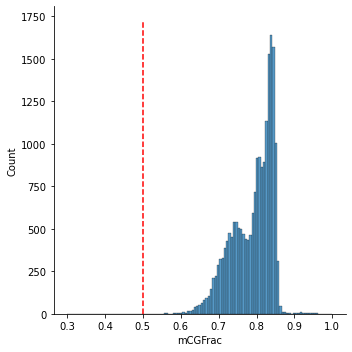

In [7]:
_cutoff = mcg_cutoff
_col_name = mcg_col_name

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0.3, 1))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

mcg_judge = metadata[_col_name] > _cutoff
_passed_cells = mcg_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

In [8]:
judge = mapping_rate_judge & final_reads_judge & mcg_judge
passed_cells = judge.sum()
print(
    f'{passed_cells} / {total_cells} cells ({passed_cells / total_cells * 100:.1f}%) '
    f'passed all the filters.')

19330 / 19944 cells (96.9%) passed all the filters.


In [9]:
metadata_filtered = metadata[judge].copy()

metadata_filtered.to_csv('CellMetadata.PassQC.csv.gz')

# 2. read metadata and mcad

In [10]:
metadata_path = 'CellMetadata.PassQC.csv.gz'
mcad_path = '../00.data/Flu.mcad'

# PC cutoff
pc_cutoff = 0.1

resolution = 1

In [12]:
metadata = pd.read_csv(metadata_path, index_col=0)
print(f'Metadata of {metadata.shape[0]} cells')
metadata.head()

Metadata of 19330 cells


Plate PCRIndex  MultiplexGroup RandomIndex  Col384  \
Flu_18_1-6-M17-A11  Flu_18_1      M17               6         A11      10   
Flu_18_1-6-M17-A12  Flu_18_1      M17               6         A12      11   
Flu_18_1-6-M17-A23  Flu_18_1      M17               6         A23      22   
Flu_18_1-6-M17-A24  Flu_18_1      M17               6         A24      23   
Flu_18_1-6-M17-B11  Flu_18_1      M17               6         B11      10   

                    Row384  R1InputReads  R1InputReadsBP  R1WithAdapters  \
Flu_18_1-6-M17-A11       0       1599394       222904045            1601   
Flu_18_1-6-M17-A12       0       1709662       237724094            2189   
Flu_18_1-6-M17-A23       0       1705306       236965967            1550   
Flu_18_1-6-M17-A24       0       1574805       220615926            1275   
Flu_18_1-6-M17-B11       1       1375381       192497761            1423   

                    R1QualTrimBP  ...  mCCCFrac  GenomeCov  \
Flu_18_1-6-M17-A11        417934  ...  0.006438   0.044833   
Flu_18_1-6-M17-A12        499919  ...  0.011564   0.045601   
Flu_18_1-6-M17-A23        453545  ...  0.005162   0.045971   
Flu_18_1-6-M17-A24        386997  ...  0.004874   0.043548   
Flu_18_1-6-M17-B11        413709  ...  0.005748   0.039133   

                    CellInputReadPairs  CellBarcodeRatio  FinalmCReads  \
Flu_18_1-6-M17-A11             1599394          0.002790       1295745   
Flu_18_1-6-M17-A12             1709662          0.002982       1320728   
Flu_18_1-6-M17-A23             1705306          0.002975       1377510   
Flu_18_1-6-M17-A24             1574805          0.002747       1248261   
Flu_18_1-6-M17-B11             1375381          0.002399       1112112   

                    sampleID  cell_type  Day  Donor  MappingRate  
Flu_18_1-6-M17-A11    Flu_18     Tc-Mem  D28     S9        68.45  
Flu_18_1-6-M17-A12    Flu_18     Tc-Mem  D28     S9        65.75  
Flu_18_1-6-M17-A23    Flu_18     Tc-Mem  D28     S9        64.55  
Flu_18_1-6-M17-A24    Flu_18     Tc-Mem  D28     S9        64.60  
Flu_18_1-6-M17-B11    Flu_18     Tc-Mem  D28     S9        68.10  

[5 rows x 70 columns]

In [63]:
mcad = anndata.read_h5ad(mcad_path)
mcad.X = mcad.X.astype(np.float32)

In [64]:
mcad =mcad[metadata.index]

In [65]:
mcad.obs = pd.concat([mcad.obs, metadata.reindex(mcad.obs_names)], axis=1)
mcad

AnnData object with n_obs × n_vars = 19330 × 617669
    obs: 'Plate', 'PCRIndex', 'MultiplexGroup', 'RandomIndex', 'Col384', 'Row384', 'R1InputReads', 'R1InputReadsBP', 'R1WithAdapters', 'R1QualTrimBP', 'R1TrimmedReads', 'R1TrimmedReadsBP', 'R1TrimmedReadsRate', 'R1UniqueMappedReads', 'R1MappingRate', 'R1UnmappedReads', 'R1UnuniqueMappedReads', 'R1OT', 'R1OB', 'R1CTOT', 'R1CTOB', 'R1TotalC', 'R1TotalmCGRate', 'R1TotalmCHGRate', 'R1TotalmCHHRate', 'R1MAPQFilteredReads', 'R1DuplicatedReads', 'R1DuplicationRate', 'R1FinalBismarkReads', 'R2InputReads', 'R2InputReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReads', 'R2TrimmedReadsBP', 'R2TrimmedReadsRate', 'R2UniqueMappedReads', 'R2MappingRate', 'R2UnmappedReads', 'R2UnuniqueMappedReads', 'R2OT', 'R2OB', 'R2CTOT', 'R2CTOB', 'R2TotalC', 'R2TotalmCGRate', 'R2TotalmCHGRate', 'R2TotalmCHHRate', 'R2MAPQFilteredReads', 'R2DuplicatedReads', 'R2DuplicationRate', 'R2FinalBismarkReads', 'mCHmC', 'mCHCov', 'mCHFrac', 'mCGmC', 'mCGCov', 'mCGFrac

In [66]:
binarize_matrix(mcad, cutoff=0.95)
# filter_regions(mcad, hypo_cutoff=6)
remove_black_list_region(mcad, black_list_path='/gale/netapp/DoD/wenliang/database/Blacklist/lists/hg38-blacklist.v2.bed.gz')

45816 features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


In [67]:
from scipy.stats import zscore

mcad.var['n_cell'] = mcad.X.sum(axis=0).A1
mcad._inplace_subset_var(mcad.var['n_cell']>5)
mcad._inplace_subset_var(np.abs(zscore(np.log(mcad.var['n_cell'])))<2)

In [68]:
exclude_chroms = mcad.var['chrom'].apply(lambda x: x not in ['chrX', 'chrY', 'chrM'])

In [69]:
mcad = mcad[:,exclude_chroms.index[exclude_chroms]]

In [70]:
mcad

View of AnnData object with n_obs × n_vars = 19330 × 489020
    obs: 'Plate', 'PCRIndex', 'MultiplexGroup', 'RandomIndex', 'Col384', 'Row384', 'R1InputReads', 'R1InputReadsBP', 'R1WithAdapters', 'R1QualTrimBP', 'R1TrimmedReads', 'R1TrimmedReadsBP', 'R1TrimmedReadsRate', 'R1UniqueMappedReads', 'R1MappingRate', 'R1UnmappedReads', 'R1UnuniqueMappedReads', 'R1OT', 'R1OB', 'R1CTOT', 'R1CTOB', 'R1TotalC', 'R1TotalmCGRate', 'R1TotalmCHGRate', 'R1TotalmCHHRate', 'R1MAPQFilteredReads', 'R1DuplicatedReads', 'R1DuplicationRate', 'R1FinalBismarkReads', 'R2InputReads', 'R2InputReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReads', 'R2TrimmedReadsBP', 'R2TrimmedReadsRate', 'R2UniqueMappedReads', 'R2MappingRate', 'R2UnmappedReads', 'R2UnuniqueMappedReads', 'R2OT', 'R2OB', 'R2CTOT', 'R2CTOB', 'R2TotalC', 'R2TotalmCGRate', 'R2TotalmCHGRate', 'R2TotalmCHHRate', 'R2MAPQFilteredReads', 'R2DuplicatedReads', 'R2DuplicationRate', 'R2FinalBismarkReads', 'mCHmC', 'mCHCov', 'mCHFrac', 'mCGmC', 'mCGCov', 

# 3. Clustering

In [48]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return

In [71]:
lsi(mcad, algorithm='arpack', obsm='X_pca', n_components=100)
n_components = significant_pc_test(mcad, p_cutoff=pc_cutoff, update=False)
mcad.obsm['5kCG_pca'] = mcad.obsm['X_pca'].copy()

40 components passed P cutoff of 0.1.


In [72]:
mcad.obsm['X_pca'] = mcad.obsm['5kCG_pca'][:, :32]
sc.pp.neighbors(mcad)
sc.tl.leiden(mcad, resolution=resolution)

# T-SNE

In [73]:
tsne(mcad, obsm='X_pca', metric='euclidean', exaggeration=-1, perplexity=30, n_jobs=-1)
dump_embedding(mcad, 'tsne')

In [74]:
mcad.obsm['5kCG_tsne'] = mcad.obsm['X_tsne'].copy()
mcad.obs['all_tsne_0'] = mcad.obs['tsne_0']
mcad.obs['all_tsne_1'] = mcad.obs['tsne_1']
mcad.obs['all_leiden'] = mcad.obs['leiden']

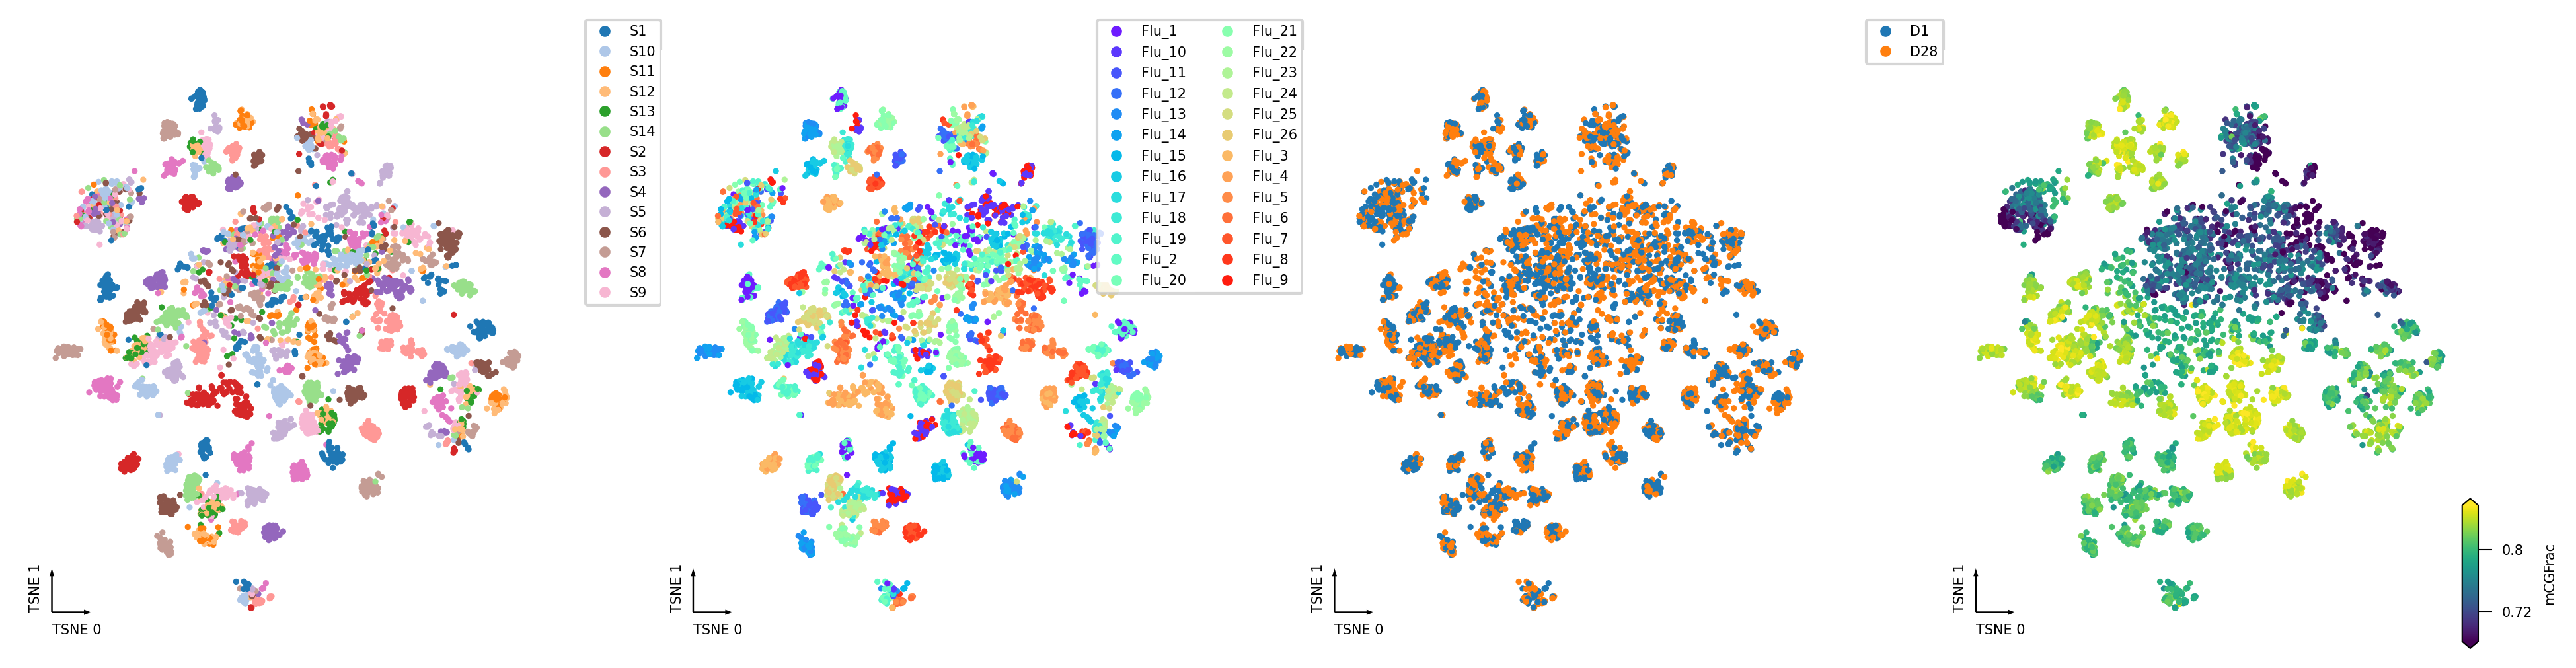

In [75]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='tsne', hue='Donor', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='tsne', hue='sampleID', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='tsne', hue='Day', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='tsne', hue='mCGFrac', labelsize=5)


In [76]:
mcad.write_h5ad("Flu.All.TSNE.mcad")

/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Plate' as categorical
/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'PCRIndex' as categorical
/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_

# Harmony

In [60]:
import scanpy.external as sce

In [79]:
sce.pp.harmony_integrate(mcad, 'Donor', max_iter_harmony=30, random_state=0)
mcad.obsm['5kCG_u30hm'] = mcad.obsm['X_pca_harmony'].copy()
sc.pp.neighbors(mcad, use_rep="5kCG_u30hm")
sc.tl.leiden(mcad, resolution=0.5)

tsne(mcad, obsm='5kCG_u30hm', metric='euclidean', exaggeration=-1, perplexity=30, n_jobs=10)
dump_embedding(mcad, 'tsne')
mcad.obs['HM_tsne_0'] = mcad.obs['tsne_0']
mcad.obs['HM_tsne_1'] = mcad.obs['tsne_1']
mcad.obs['HM_leiden'] = mcad.obs['leiden']

mcad.obsm['5kCG_u30hm_tsne'] = mcad.obsm['X_tsne'].copy()

2022-06-09 16:19:43,254 - harmonypy - INFO - Iteration 1 of 30
2022-06-09 16:20:02,765 - harmonypy - INFO - Iteration 2 of 30
2022-06-09 16:20:24,038 - harmonypy - INFO - Iteration 3 of 30
2022-06-09 16:20:45,638 - harmonypy - INFO - Iteration 4 of 30
2022-06-09 16:20:53,475 - harmonypy - INFO - Iteration 5 of 30
2022-06-09 16:21:00,924 - harmonypy - INFO - Iteration 6 of 30
2022-06-09 16:21:06,685 - harmonypy - INFO - Iteration 7 of 30
2022-06-09 16:21:11,646 - harmonypy - INFO - Iteration 8 of 30
2022-06-09 16:21:16,203 - harmonypy - INFO - Converged after 8 iterations


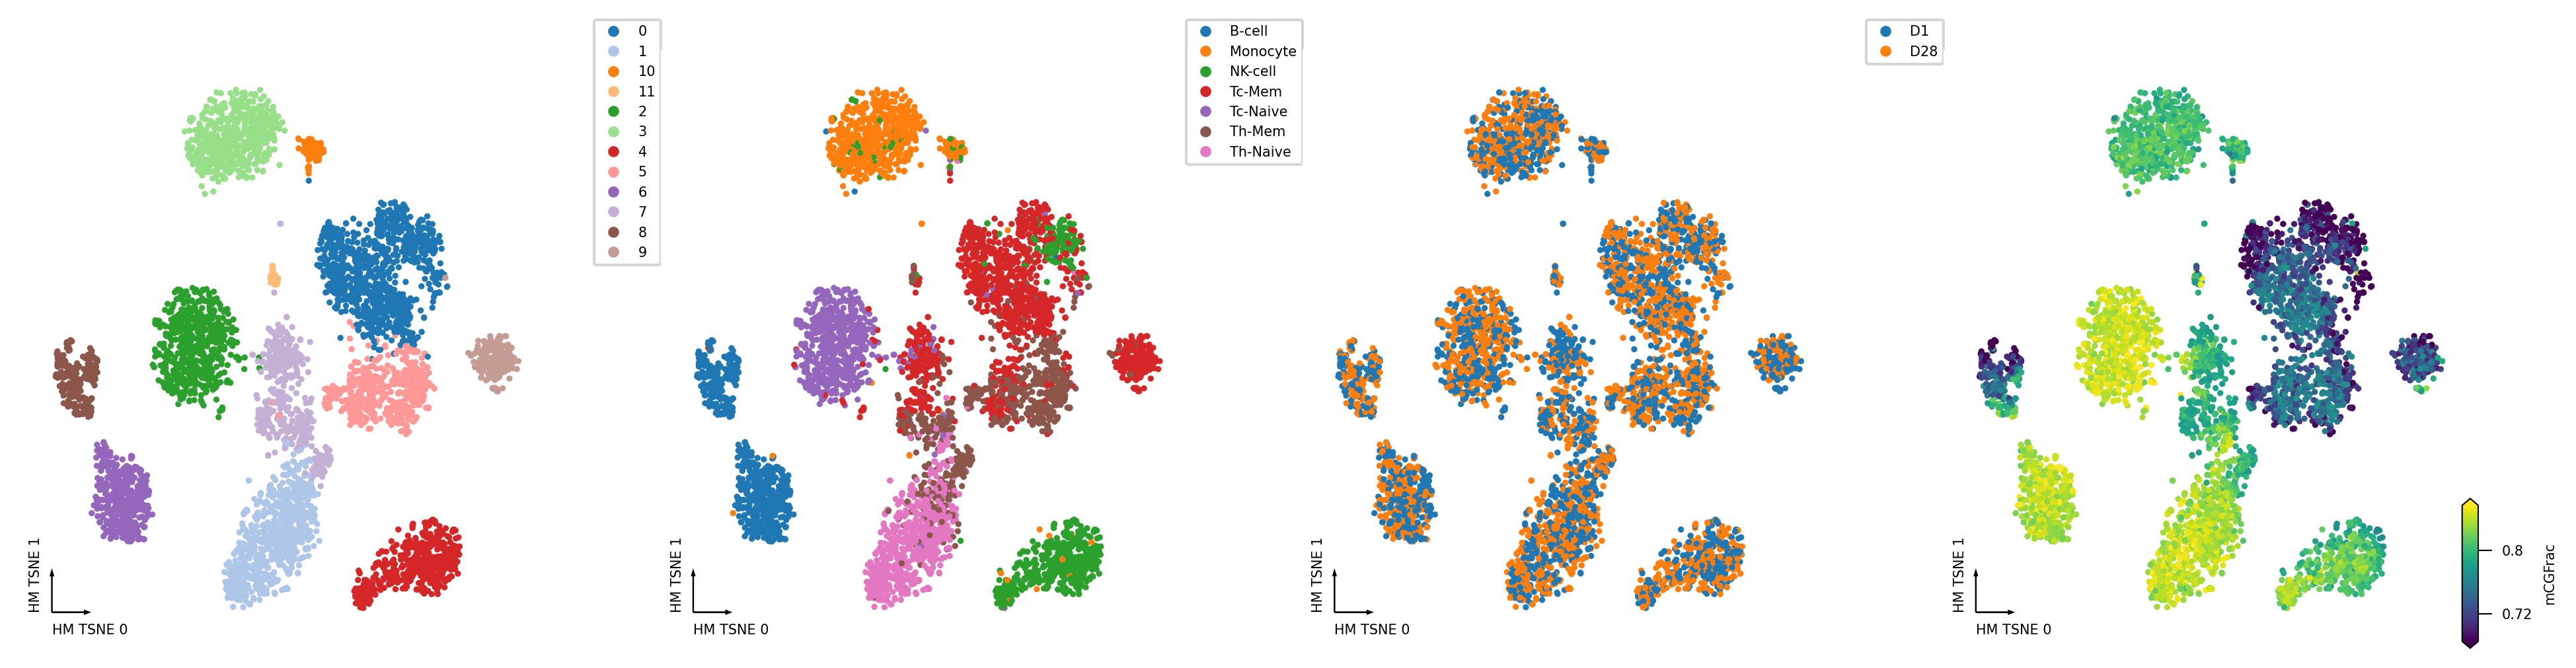

In [80]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='HM_tsne', hue='HM_leiden', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='HM_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='HM_tsne', hue='Day', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='HM_tsne', hue='mCGFrac', labelsize=5)


In [81]:
mcad.write_h5ad("Flu.All.TSNE.HM.mcad")

# 3. Cell type annotation

In [82]:
import xarray as xr
import pybedtools
import dask
from ALLCools.plot import *
from ALLCools.mcds import MCDS
import pathlib
import glob

In [83]:
gene_meta_path = '/gale/netapp/DoD/wenliang/database/ref/hg38/Annotation/gencode.v35.annotation.gene.withName.bed'
chrom_to_remove = ['chrM', 'chrX', 'chrY']

# change this to the paths to your MCDS files
mcds_path_list = glob.glob("/gale/netapp/DoD/wenliang/projects/06.Flu/02.clustering/00.data/MCDS/*.mcds")
obs_dim = 'cell'
var_dim = 'gene'

min_cov = 5

In [84]:
gene_meta = pd.read_csv(gene_meta_path, sep='\t', names=['chrom', 'start', 'end', 'gene_id', 'gene_name'], index_col=3)

genes_to_skip = set()

# skip smaller genes mostly covered by a larger gene, e.g., a miRNA within a protein coding gene.
# F=0.9 means > 90% of gene_b is overlapped with gene_a, in this case, we only keep gene_a for DMG test
gene_bed = pybedtools.BedTool.from_dataframe(
    gene_meta.reset_index()[['chrom', 'start', 'end', 'gene_id']])
mapped_bam = gene_bed.map(b=gene_bed, c=4, o='distinct', F=0.9)
for _, (*_, gene_a, gene_b_str) in mapped_bam.to_dataframe().iterrows():
    for gene_b in gene_b_str.split(','):
        if gene_b != gene_a:
            genes_to_skip.add(gene_b)

# remove certain chromosomes
genes_to_skip |= set(gene_meta.index[gene_meta['chrom'].isin(chrom_to_remove)])
use_features = gene_meta.index[~gene_meta.index.isin(genes_to_skip)]
print(f'{use_features.size} features remained')

36763 features remained


In [85]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    # still use all the cells to load MCDS
    mcds = MCDS.open(mcds_path_list, obs_dim=obs_dim, use_obs=metadata.index)

Feature gene mean cov across cells added in MCDS.coords['gene_cov_mean'].


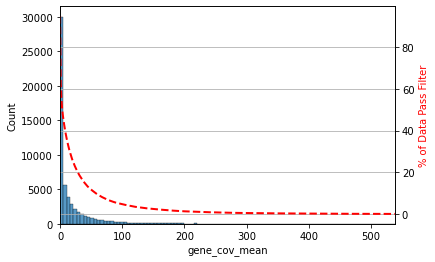

In [86]:
mcds.add_feature_cov_mean(var_dim=var_dim, obs_dim=obs_dim)

In [87]:
feature_cov_mean = mcds.coords[f'{var_dim}_cov_mean'].to_pandas()

In [88]:
use_features &= feature_cov_mean[feature_cov_mean > min_cov].index

print(f'{use_features.size} features remained')

22366 features remained


/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  """Entry point for launching an IPython kernel.


In [89]:
mcds.filter_feature_by_cov_mean(var_dim, min_cov=min_cov)

Before cov mean filter: 60656 gene
 After cov mean filter: 27898 gene 46.0%


<xarray.MCDS>
Dimensions:              (gene: 27898, cell: 19330, count_type: 2, chrom100k: 30895)
Coordinates: (12/13)
  * gene                 (gene) object 'ENSG00000279457' ... 'ENSG00000229236'
    gene_chrom           (gene) <U1 dask.array<chunksize=(2003,), meta=np.ndarray>
    gene_start           (gene) int32 dask.array<chunksize=(2003,), meta=np.ndarray>
    gene_end             (gene) int32 dask.array<chunksize=(2003,), meta=np.ndarray>
  * cell                 (cell) <U18 'Flu_1_1-1-I3-B2' ... 'Flu_26_2-6-I15-P24'
  * count_type           (count_type) <U3 'mc' 'cov'
    ...                   ...
    mc_type              <U3 'CGN'
    chrom100k_chrom      (chrom100k) <U1 dask.array<chunksize=(4096,), meta=np.ndarray>
  * chrom100k            (chrom100k) int32 0 1 2 3 4 ... 30891 30892 30893 30894
    chrom100k_bin_start  (chrom100k) int32 dask.array<chunksize=(4096,), meta=np.ndarray>
    chrom100k_bin_end    (chrom100k) int32 dask.array<chunksize=(4096,), meta=np.ndarray>
    gene_cov_mean        (gene) float64 5.387 57.66 8.952 ... 16.54 7.907 5.525
Data variables:
    gene_da              (cell, gene, count_type) int32 dask.array<chunksize=(3866, 2003, 1), meta=np.ndarray>
    chrom100k_da         (cell, chrom100k, count_type) int32 dask.array<chunksize=(3866, 4096, 1), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  null

In [90]:
gene_frac_dir = pathlib.Path('gene_frac_raw')
gene_frac_dir.mkdir(exist_ok=True)

In [91]:
for mcds_path in mcds_path_list:
    output_path = gene_frac_dir / (pathlib.Path(mcds_path).name + f'{var_dim}_da_frac.mcds')
    if output_path.exists():
        continue
    print(f'Computaing gene mC fraction for {mcds_path}')
    mcds = MCDS.open(mcds_path, obs_dim=obs_dim)
    # remove non-related data
    del_das = []
    for da in mcds:
        if da != f'{var_dim}_da':
            del_das.append(da)
    for da in del_das:
        del mcds[da]
    mcds.load()
    mcds = mcds.sel({var_dim: use_features})
    mcds.add_mc_rate(var_dim=var_dim, normalize_per_cell=True, clip_norm_value=10)
    # use float32 to reduce file size and speedup IO
    mcds = mcds.rename({var_dim: 'gene', f'{var_dim}_da_frac': 'gene_da_frac'})
    mcds['gene_da_frac'].astype('float32').to_netcdf(output_path)

Computaing gene mC fraction for /gale/netapp/DoD/wenliang/projects/06.Flu/02.clustering/00.data/MCDS/Fluaa_0.mcds
Computaing gene mC fraction for /gale/netapp/DoD/wenliang/projects/06.Flu/02.clustering/00.data/MCDS/Fluaa_1.mcds
Computaing gene mC fraction for /gale/netapp/DoD/wenliang/projects/06.Flu/02.clustering/00.data/MCDS/Fluab_0.mcds
Computaing gene mC fraction for /gale/netapp/DoD/wenliang/projects/06.Flu/02.clustering/00.data/MCDS/Fluab_1.mcds
Computaing gene mC fraction for /gale/netapp/DoD/wenliang/projects/06.Flu/02.clustering/00.data/MCDS/Fluac_0.mcds
Computaing gene mC fraction for /gale/netapp/DoD/wenliang/projects/06.Flu/02.clustering/00.data/MCDS/Fluac_1.mcds
Computaing gene mC fraction for /gale/netapp/DoD/wenliang/projects/06.Flu/02.clustering/00.data/MCDS/Fluad_0.mcds
Computaing gene mC fraction for /gale/netapp/DoD/wenliang/projects/06.Flu/02.clustering/00.data/MCDS/Fluad_1.mcds
Computaing gene mC fraction for /gale/netapp/DoD/wenliang/projects/06.Flu/02.clustering/

In [92]:
use_gene_meta = gene_meta.loc[use_features]
use_gene_meta.to_csv(gene_frac_dir / 'GeneMetadata.csv.gz')

In [93]:
Markers = ['CD38', 'CXCR5', 'CD34', 'CD80', 'TNFRSF13B', 'CD40', 'IGHM', 'CD5', 'MS4A1', 'CD24', 'CD79A', 'CXCR4', 'CD22', 'IGHD']\
        + ['CD14', 'CD36', 'CCR2', 'CD74', 'CLEC9A']\
        + ['NCAM1']\
        + ['MKI67']\
        + ['CD4', 'CD40LG', 'CD8A', 'CD8B', 'SELL', 'CCR7', 'NR4A1', 'CX3CR1', 'CD45RA']

In [94]:
gene_meta = pd.read_csv(f'{gene_frac_dir}/GeneMetadata.csv.gz', index_col=0)
gene_meta.index.name = 'gene_id'

name2id = dict(zip(gene_meta['gene_name'], gene_meta.index))
marker_gene_ids = [name2id[x] for x in Markers if x in name2id]

gene_frac_da = MCDS.open(f'{gene_frac_dir}/*_da_frac.mcds')[f'gene_da_frac']
gene_frac_da = gene_frac_da.expand_dims(dim={'mc_type': ['CGN']})
genes_data = gene_frac_da.sel(mc_type='CGN').sel(gene=marker_gene_ids).squeeze().to_pandas()
genes_data.columns = genes_data.columns.map(gene_meta['gene_name'])
genes_data

gene                    CD38     CXCR5      CD34      CD80  TNFRSF13B  \
cell                                                                    
Flu_1_1-1-I3-B2     1.152432  0.806863  1.074950  1.144295   0.960484   
Flu_1_1-1-I3-A14    1.214958  0.878146  1.071293  1.228053   0.953312   
Flu_1_1-1-I3-C13    1.140547  1.076674  0.913557  1.260953   1.088107   
Flu_1_1-1-I3-A2     1.171222  1.332259  1.301517  0.947818   0.886044   
Flu_1_1-1-I3-B13    1.210811  1.271467  1.097703  1.366853   0.903882   
...                      ...       ...       ...       ...        ...   
Flu_26_2-6-I15-O11  1.152954  1.179145  0.857240  1.179145   1.213387   
Flu_26_2-6-I15-P11  0.841925  1.120609  1.199174  1.071017   1.043483   
Flu_26_2-6-I15-P23  1.192743  1.114768  0.602982  1.107375   1.040962   
Flu_26_2-6-I15-P12  1.004182  0.752956  0.647454  1.207679   0.998335   
Flu_26_2-6-I15-P24  1.198722  1.102916  0.894570  1.131957   0.994406   

gene                    CD40      IGHM       CD5     MS4A1      CD24  ...  \
cell                                                                  ...   
Flu_1_1-1-I3-B2     0.978552  1.326608  1.224605  0.704703  0.146219  ...   
Flu_1_1-1-I3-A14    1.276795  1.258387  1.077865  0.916490  0.102699  ...   
Flu_1_1-1-I3-C13    0.906353  0.647116  1.077536  0.906353  0.042233  ...   
Flu_1_1-1-I3-A2     0.527706  1.355209  1.156005  0.875042  1.000000  ...   
Flu_1_1-1-I3-B13    1.200019  1.440027  1.371725  0.897604  1.000000  ...   
...                      ...       ...       ...       ...       ...  ...   
Flu_26_2-6-I15-O11  1.162224  1.000000  0.915348  0.985638  0.612973  ...   
Flu_26_2-6-I15-P11  1.199174  1.205288  0.939317  1.188764  0.069900  ...   
Flu_26_2-6-I15-P23  1.134403  1.162142  0.920253  1.146975  0.122547  ...   
Flu_26_2-6-I15-P12  1.190401  1.154224  1.060823  1.140264  1.081353  ...   
Flu_26_2-6-I15-P24  0.175054  1.165979  1.152779  1.000000  0.077103  ...   

gene                    CD74    CLEC9A     NCAM1     MKI67       CD4  \
cell                                                                   
Flu_1_1-1-I3-B2     1.120010  1.048539  0.853234  1.198462  1.000000   
Flu_1_1-1-I3-A14    1.034291  1.064516  0.985741  1.208512  1.125716   
Flu_1_1-1-I3-C13    1.178369  0.960188  1.096067  1.155493  1.112329   
Flu_1_1-1-I3-A2     0.715129  1.332501  1.118304  1.004907  0.892864   
Flu_1_1-1-I3-B13    0.904814  1.185560  0.777648  1.107652  1.128706   
...                      ...       ...       ...       ...       ...   
Flu_26_2-6-I15-O11  1.195455  1.141101  0.834209  0.577681  1.096667   
Flu_26_2-6-I15-P11  0.947293  1.199174  1.157423  0.532348  1.210308   
Flu_26_2-6-I15-P23  0.760031  1.117574  0.954100  1.162142  1.185059   
Flu_26_2-6-I15-P12  1.070915  1.164018  1.082706  0.779563  1.138780   
Flu_26_2-6-I15-P24  1.186806  1.030727  1.018880  0.559463  1.168088   

gene                    CD8A      CD8B      CCR7     NR4A1    CX3CR1  
cell                                                                  
Flu_1_1-1-I3-B2     0.438036  0.257687  1.000000  0.605877  0.865326  
Flu_1_1-1-I3-A14    0.103544  0.348344  0.891976  0.904982  1.191304  
Flu_1_1-1-I3-C13    0.756374  1.078895  1.121184  0.547061  0.651856  
Flu_1_1-1-I3-A2     0.131188  0.917125  1.056076  0.704340  0.807141  
Flu_1_1-1-I3-B13    0.459118  0.330392  0.911443  0.718079  1.084759  
...                      ...       ...       ...       ...       ...  
Flu_26_2-6-I15-O11  0.691133  0.552710  0.312022  1.058679  0.924736  
Flu_26_2-6-I15-P11  0.048915  0.707145  0.675893  0.942725  1.146024  
Flu_26_2-6-I15-P23  0.175929  0.550825  0.821448  1.075656  1.000000  
Flu_26_2-6-I15-P12  0.145496  0.444852  0.417162  0.517903  1.152613  
Flu_26_2-6-I15-P24  0.600606  0.463886  0.871315  0.640276  1.140026  

[19937 rows x 25 columns]

In [95]:
genes_data = genes_data.loc[mcad.obs.index].drop_duplicates()
genes_data = genes_data[~genes_data.index.duplicated(keep='first')]

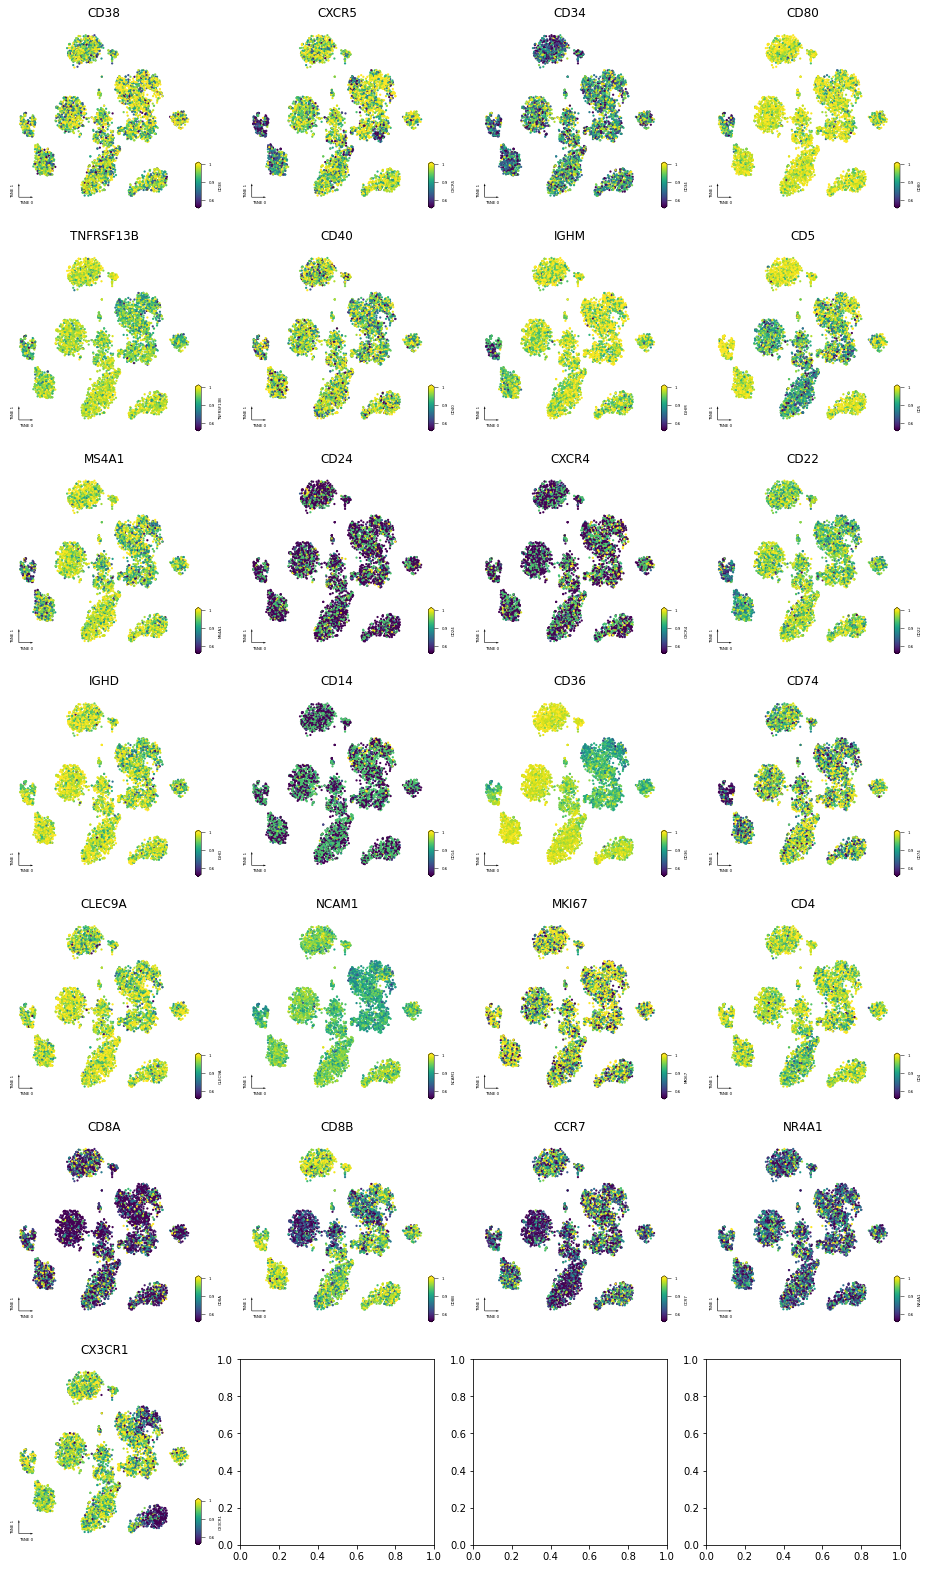

In [96]:
fig, axes = plt.subplots(7, 4, figsize=(16, 28))
axes = axes.flatten()
for i, (gene, data) in enumerate(genes_data.iteritems()):
    ax = axes[i]
    continuous_scatter(ax=ax,
                       data=mcad.obs,
                       hue=data,
                       coord_base='tsne',
                      hue_norm=[0.5, 1.2])
    ax.set_title(f'{data.name}')

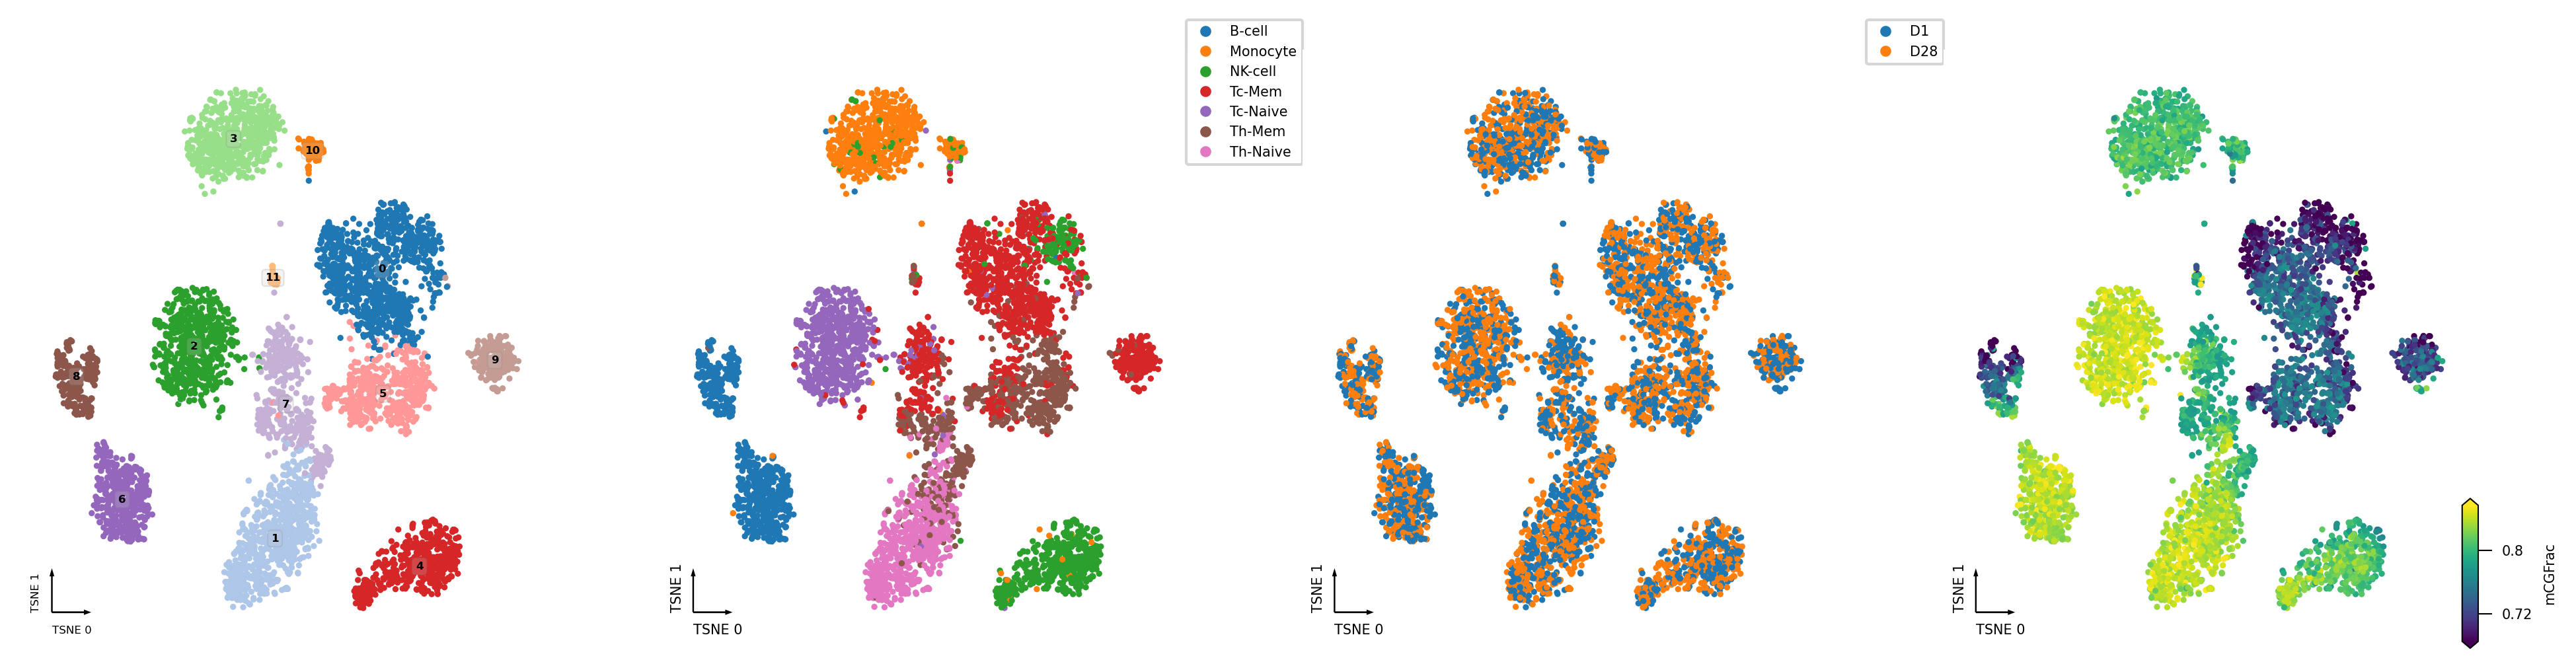

In [99]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='tsne', hue='HM_leiden', show_legend=False, 
#                         legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
                            text_anno="leiden")
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='tsne', hue='Day', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='tsne', hue='mCGFrac', labelsize=5)
plt.savefig("all_cluster.pdf")

In [98]:
leiden2celltype = {4: 'NK-cell2',
                  6: 'B-Naive',
                  8: 'B-Mem'}

In [100]:
mcad.obs['annotation'] = mcad.obs.apply(lambda row: leiden2celltype[int(row['HM_leiden'])] if int(row['HM_leiden']) in leiden2celltype else row['cell_type'], axis=1)

In [101]:
mcad.write_h5ad('Flu.All.TSNE.HM.Annotation.mcad')

/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'annotation' as categorical


In [102]:
mcad.obs.to_csv("cell2cluster.csv")

In [1]:
import anndata

In [2]:
mcad = anndata.read_h5ad("Flu.All.TSNE.HM.Annotation.mcad")

In [7]:
from collections import defaultdict, Counter
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='tsne', hue='HM_leiden', show_legend=False, 
#                         legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
                            text_anno="leiden")
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='tsne', hue='Day', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='tsne', hue='mCGFrac', labelsize=5)
plt.savefig("all_cluster.pdf")

In [2]:
cell2cluster = pd.read_csv('cell2cluster.csv')

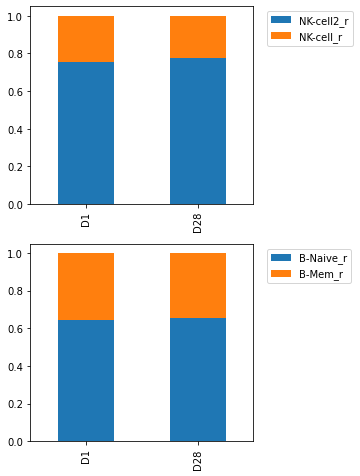

In [9]:
fig, axes = plt.subplots(2,1, figsize=(4,8))
for i, celltype in enumerate(['NK-cell', 'B-cell']):
    cell_df = cell2cluster[cell2cluster['cell_type'] == celltype]
    count_dict = cell_df[['Day', 'annotation']].value_counts().to_dict()
    
    cell_counter = defaultdict(Counter)
    for (cond, cell) in count_dict:
        if count_dict[(cond, cell)] < 50:
            continue
        cell_counter[cond][cell] = count_dict[(cond, cell)]
        cell_counter[cond]['total'] += count_dict[(cond, cell)]
    cell_counter_df = pd.DataFrame.from_dict(cell_counter, orient='index')
    for cell in cell_counter_df.columns:
        if cell == 'total':
            continue
        cell_counter_df[f'{cell}_r'] = cell_counter_df.apply(lambda row: row[cell] / row['total'], axis=1)
    cell_counter_df[[x for x in cell_counter_df.columns if x.endswith("_r")]].sort_index().plot.bar(stacked=True, ax=axes[i])
    axes[i].legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('Flu_B-NK_ratio.pdf')